In [1]:
# ------------------------------------------------------------------------------
# Imports
# ------------------------------------------------------------------------------
import os
import sys
import shutil

import csv
import math
import time

import numpy as np
import pandas as pd

import PIL
from PIL import Image

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

from IPython.display import display

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

# ------------------------------------------------------------------------------
# Paths
# ------------------------------------------------------------------------------
path_to_repo = '/content/drive/MyDrive/UOC/Semestre\ 10/TFG\ -\ Inteligencia\ Artificial/Repo/cnn-gan-superresolution'
path_to_models = f'{path_to_repo}/models/*.py'
path_to_utils = f'{path_to_repo}/utils/*.py'
path_to_dataset = f'{path_to_repo}/data/BSDS500/*'
path_to_dataset_train = f'{path_to_dataset}/train'
path_to_dataset_valid =f'{path_to_dataset}/val'
path_to_dataset_test = f'{path_to_dataset}/test'

# ------------------------------------------------------------------------------
# Setup
# ------------------------------------------------------------------------------
# Models
#!cp $path_to_models .

# Utils
!cp $path_to_utils .

# Data
!cp -R $path_to_dataset .

#sys.path.insert(1, '.')

# Scripts imports
from constants import *
from data_preprocessing import get_data_sets

!ls | grep '**\.py'

constants.py
data_preprocessing.py


Found 200 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 200 files belonging to 1 classes.


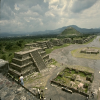

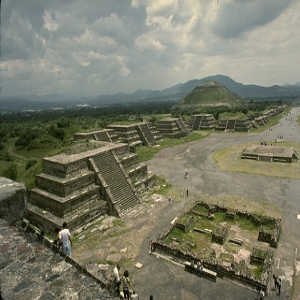

In [2]:
train_ds, valid_ds, test_ds = get_data_sets()

for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img[1]))